# Poyecciones de contagio de COVID-19 utilizando IA

Proyecciones de contagio de COVID-19 a dos meses utilizando algoritmos de inteligencia artifdicial de regresion, con datos optenidos de Open data Colombia https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data

##### Importacion de librerias requeridas

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3 as db

%matplotlib inline
tf.__version__

'2.3.1'

## 1. descarga de los datos de COVID-19 de Interntet

Ejecutar la celda de abajo unicamente si no se tiene la base de datos

In [ ]:
url = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
column_names = ['ID de caso','Fecha de notificación','Nombre departamento','Nombre municipio',
                'Edad','Sexo','Ubicación del caso','Estado','Nombre del país','Recuperado',
                'Fecha de inicio de síntomas','Fecha de muerte','Fecha de diagnóstico','Fecha de recuperación']
date_data = ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación']
csv_data = pd.read_csv(url, header=0,usecols=column_names, parse_dates=date_data, dayfirst=True, low_memory=False)

In [ ]:
csv_data.head()

## 2. Almacenamiento de los datos en una base de datos sqlite

In [2]:
database_name = "datasets/covid.db"
table_name = 'covid_data'
conn = db.connect(database_name)

Ejecutar la celda de abajo unicamente si no se tiene la base de datos o se desea altualizar los datos y se descargaron utilizando la celda del apartado 1.

In [ ]:
csv_data.to_sql(table_name, conn, if_exists='replace', index=False)

## 3. Optener el numero de contagios agrupados por fecha de diagnostico

In [3]:
query = f'SELECT "Fecha de notificación" as fecha, count(*) as cantidad FROM {table_name} GROUP BY fecha ORDER BY fecha'
covid_data = pd.read_sql(query, conn, parse_dates=['fecha'])

In [4]:
covid_data.set_index('fecha', inplace=True)
print(f'cantidad de datos optenidos {covid_data.shape}')
covid_data.tail()#muesta de los datos obtenidos en la consulta a la base de datos

cantidad de datos optenidos (275, 1)


,cantidad
fecha,
2020-11-30,5257
2020-12-01,3403
2020-12-02,1318
2020-12-03,316
2020-12-04,2


In [ ]:
covid_data.info() # tipo de datos obtenidos en la consulta

<AxesSubplot:title={'center':'Cantidad de contagios por dia'}, xlabel='fecha'>

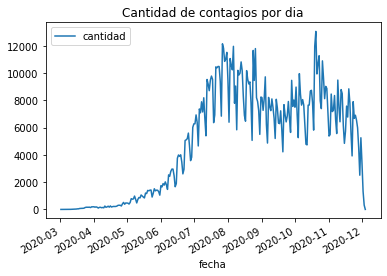

In [5]:
covid_data.plot(kind='line', title='Cantidad de contagios por dia')

## 4. Normalizacion del dato de tiempo

Para realizar la pyroyeccion de contagios utilizando un algoritmo de inteligencia artificia de regresion se utiliza como variable independiente la fecha en la que se realiza el reporte expresada en dias del año.

In [6]:
# de la fecha se toma el dia del año que representa y se divide en los dias totales del año
covid_data['day'] = covid_data.index.dayofyear / 366

In [7]:
covid_data.tail()

,cantidad,day
fecha,,
2020-11-30,5257,0.915301
2020-12-01,3403,0.918033
2020-12-02,1318,0.920765
2020-12-03,316,0.923497
2020-12-04,2,0.926230


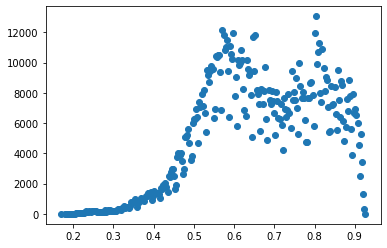

In [8]:
plt.scatter(covid_data['day'], covid_data['cantidad'])

## 5. limpieza del numero de contagios por dia

Los datos obtenidos de internet se actualizan lentamente, por lo que los ultimos dias generados no tienen la cantidad total de contagios en ese dia. Por lo tanto se toman los valores hasta el 30 de noviembre del 2020

In [9]:
covid_data_train = covid_data[:'2020-11-30']

In [10]:
covid_data_train.tail()

,cantidad,day
fecha,,
2020-11-26,6554,0.904372
2020-11-27,5988,0.907104
2020-11-28,4540,0.909836
2020-11-29,2510,0.912568
2020-11-30,5257,0.915301


In [11]:
covid_data_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cantidad,271.0,4972.575646,3791.186773,1.000000,844.000000,5599.000000,7990.000000,13057.000000
day,271.0,0.546418,0.214193,0.169399,0.362022,0.546448,0.730874,0.915301


### 5.1 Separacion de la varible independiente y la variable dependiente del set de datos

In [12]:
x = covid_data_train.copy()
y = x.pop('cantidad')

## 6. Modelo de regresión lineal 

Observando el tipo de datos que se tiene y observando las graficas se pude inferir que el modelo que mejor se adapta a esta condición es un modelo periodico que puede ser ajustado mediante minimos cuadrados, expresando el modelo periodico en un sistema lineal

$$
y = c_1 + c_2cos(2\pi x) + c_3sin(2\pi x)
$$

In [13]:
def model_periodico(X, Y):
    t = np.array(X)
    v = np.ones(X.shape, dtype='float64')
    cos = tf.math.cos(2. * np.pi * t)
    sin = tf.math.sin(2. * np.pi * t)
    A = tf.constant(np.append(np.append(v, cos, axis=1), sin, axis=1)) # matriz de coeficientes
    B = tf.constant(np.expand_dims(np.array(Y), axis=1), dtype='float64') # vector de valores independeintes
    grads = tf.linalg.lstsq(A, B) # valores de k y de c_2 utilizando minimos cuadrados
    return grads

In [14]:
grads = model_periodico(x, y)
print('gradientes obtenidos por el modelo: ', grads)

gradientes obtenidos por el modelo:  tf.Tensor(
[[ 4182.45048214]
 [-1271.9005035 ]
 [-4538.56941791]], shape=(3, 1), dtype=float64)


In [15]:
# modelo periodico
t = tf.linspace(x['day'][0], x['day'][-1], len(x)+1)
y_predic_periodic = grads[0] + grads[1] * tf.math.cos(2. * np.pi * t) + grads[2] * tf.math.sin(2. * np.pi * t)

In [16]:
def plot_regression_periodic(t, y_predict, x, y):
  plt.scatter(np.array(x), np.array(y), label='Data')
  plt.plot(t, y_predict, color='k', label='Predictions')
  plt.xlabel('tiempo')
  plt.ylabel('contagios')
  plt.legend()

La siguiente grafica muestra la curva de regresion obtenida con el modelo de minimos cuadrados

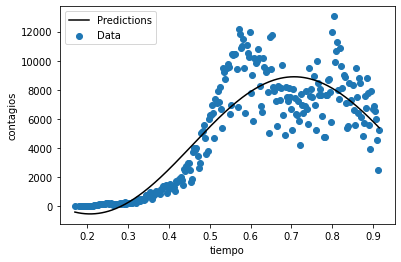

In [17]:
plot_regression_periodic(t, y_predic_periodic, x, y)

## 7. proyección para los siguioentes 2 meses

In [19]:
date_start_predict = x.index[-1]
predict_index = pd.date_range(date_start_predict+datetime.timedelta(days=1), periods=62)

In [20]:
predicted_data = pd.DataFrame(index=predict_index, columns=['cantidad', 'day'])
predicted_data['day'] = predicted_data.index.dayofyear / 366

In [21]:
t_prediction = tf.linspace(predicted_data['day'][0], predicted_data['day'][-1], len(predicted_data))
predicted_data['cantidad'] = grads[0] + grads[1] * tf.math.cos(2. * np.pi * t_prediction) + grads[2] * tf.math.sin(2. * np.pi * t_prediction)

In [22]:
predicted_data # Cantidad de contagios proyectada a dos meses a partir del 1 de diciembre de 2020

,cantidad,day
2020-12-01,5310.997844,0.918033
2020-12-02,5699.173327,0.920765
2020-12-03,6076.180765,0.923497
2020-12-04,6439.244149,0.926230
2020-12-05,6785.690146,0.928962
...,...,...
2021-01-27,-117.399013,0.073770
2021-01-28,63.952125,0.076503
2021-01-29,275.628892,0.079235
2021-01-30,516.072653,0.081967


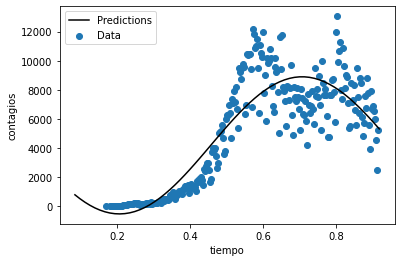

In [23]:
plot_regression_periodic(t_prediction, predicted_data['cantidad'], x, y)

Text(0.5, 1.0, 'Linea de pronostico de casos para los siguientes 2 meses')

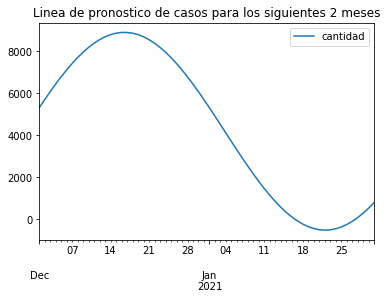

In [24]:
predicted_data.plot(y='cantidad', kind='line')
plt.title('Linea de pronostico de casos para los siguientes 2 meses')

In [26]:
total_covid_Data = pd.concat([covid_data, predicted_data])
total_covid_Data

,cantidad,day
2020-03-02,1.000000,0.169399
2020-03-06,1.000000,0.180328
2020-03-07,1.000000,0.183060
2020-03-08,2.000000,0.185792
2020-03-09,3.000000,0.188525
...,...,...
2021-01-27,-117.399013,0.073770
2021-01-28,63.952125,0.076503
2021-01-29,275.628892,0.079235
2021-01-30,516.072653,0.081967


Text(0.5, 1.0, 'linea de contagios con la adicion de la tendencia predecida para los siguientes 2 meses')

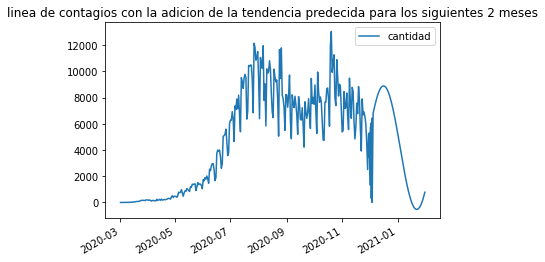

In [27]:
total_covid_Data.plot(y='cantidad')
plt.title('linea de contagios con la adicion de la tendencia predecida para los siguientes 2 meses')

Con la proyeccion realizada se puede obarservar que se pronostica un incremento en el mes de diciembre de 2020 el cual ira disminuyendo en el siguiente año